<a href="https://colab.research.google.com/github/JohanCala/Eighth-Semester/blob/main/ParcialFinaldeFundamentosDeInteligenciaArtificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Parcial Final de Fundamentos de Inteligencia Artificial
Por: Johan E. Cala Torra y Silvia M. Coy Lizarazo



##  Descripción de los datos
Esta base de datos incluye 18 grabaciones de ECG de larga duración de sujetos remitidos al **"the Arrhythmia Laboratory"** del Hospital Beth Israel de Boston (actual Centro Médico Beth Israel Deaconess). Los sujetos incluidos en esta base de datos no presentaban arritmias significativas; incluyen 5 hombres, de entre 26 y 45 años, y 13 mujeres, de entre 20 y 50 años.

[ MIT-BIH Normal Sinus Rhythm Database](https://www.physionet.org/content/nsrdb/1.0.0/)



### Configuracion del entorno 
---

para poder manejar las señales ECG necesitamos instalar el paquete **wfdb**, acompañado de las librerias para MachineLearning ofrecidas por **Sklearn** y librerias de manejo de datos como **Pandas**

In [1]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 28.1 MB/s 


In [2]:
import wfdb 
import random
import statistics as stats
from scipy.stats import kurtosis
from scipy.stats import skew
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statistics import mode
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Formacion de DataSet
---

Con el siguiente algoritmo se pudo recorrer todas señales mediantes ventanas deslizantes en busca de categorias o patrones que nos sirvan para identificar si es un latido o no es un latido.  
Las cuales fueron las siguientes:
1.  pendiente  
2.  media  
3.  mediana  
4.  moda  
5.  varianza  
6.  desviacionEstandar  
7.  kurtosis   
8.  asimetria

El algoritmpo mecionado para sacar los datos de toda la señal fue el siguiente:



```
# Algoritmo de Creacion de DataSet
def modaJC(test_list):
  res = []
  test_list1 = Counter(test_list) 
  temp = test_list1.most_common(1)[0][1] 
  for ele in test_list:
    if test_list.count(ele) == temp:
      res.append(ele)
  res = list(set(res))
  return res

# Lista de registros

registros = ['16265','16272','16273','16420','16483','16539','16773',
             '16786','16795','17052','17453',
             '18177','18184','19088','19090',
             '19093','19140','19830']
info_data = []             
N_1 = 10
N_0 = 10
y_0 = 0
y_1 = 1

for i in registros:

  ruta = "db/"+i
  print(ruta)
  records = wfdb.rdrecord(ruta)
  signal = records.p_signal
  signal1 = signal[:,0]
  signal2 = signal[:,1]
  ann = wfdb.rdann(ruta,'atr') #etiquetas del evento
  ANN = ann.sample
  print(len(ANN))
  for x in range(1,len(ANN)-1):

    REGISTRO1 = signal1[ANN[x]-N_1:ANN[x]+N_1]
    y1=np.amin(REGISTRO1)
    y2=np.amax(REGISTRO1)
    x1 = np.where(REGISTRO1 == y1)[0][0]
    x2 = np.where(REGISTRO1 == y2)[0][0]
    pendiente = y2 - y1 / x2 - x1
    media = stats.mean(REGISTRO1)
    mediana = stats.median(REGISTRO1)
    moda = modaJC(list(REGISTRO1))
    varianza = stats.pvariance(REGISTRO1)
    desviacionEstandar = stats.pstdev(REGISTRO1)
    kurt = kurtosis(REGISTRO1)
    asime = skew(REGISTRO1)
    caract_1 = [pendiente,media,mediana,moda,varianza,desviacionEstandar,kurt,asime,y_1]
    info_data.append(caract_1)

    #No latidos
    n_aux = 8 
    REGISTRO2 = signal1[ANN[x]+n_aux:ANN[x+1]-n_aux]

    options = range(len(REGISTRO2)+1)
    options= list(options)
    if len(REGISTRO2) > 30:
      aux = True
      while aux == True:
          r = random.choice(options)
          if r - N_0 > 0 and r + N_0 < len(REGISTRO2):
            aux = False
      inicio = r - N_0 
      final = r + N_0
      REGISTRO0 = REGISTRO2[inicio:final]
    else:
      n_aux = 3
      REGISTRO0 = signal1[ANN[x]:ANN[x+1]]


    y1=np.amin(REGISTRO0)
    y2=np.amax(REGISTRO0)
    x1 = np.where(REGISTRO0 == y1)[0][0]
    x2 = np.where(REGISTRO0 == y2)[0][0]
    pendiente = y2 - y1 / x2 - x1
    media = stats.mean(REGISTRO0)
    mediana = stats.median(REGISTRO0)
    moda = modaJC(list(REGISTRO0))
    varianza = stats.pvariance(REGISTRO0)
    desviacionEstandar = stats.pstdev(REGISTRO0)
    kurt = kurtosis(REGISTRO2)
    asime = skew(REGISTRO2)
    caract_0 = [pendiente,media,mediana,moda,varianza,desviacionEstandar,kurt,asime,y_0]
    info_data.append(caract_0)

```


Nota : Este algoritmo es el mismo que se uso para el desarrollo del [Parcial Final de Analitica de Datos](https://github.com/JohanCala/Eighth-Semester/blob/main/SegundoParcialAnaliticaDeDatos.ipynb)

Como Resultado nos queda el dataset que va ser trabajado en este parcial


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DatosMIT-BIH.csv')
df

,pendiente,media,mediana,moda,varianza,desviacionEstandar,kurtosis,asimetria,salida
0,-5.253750,0.2545,-0.195,-0.155,1.132965,1.064408,0.529401,1.436697,1
1,-0.051562,-0.1475,-0.155,-0.175,0.001529,0.039099,0.832477,-0.537550,0
2,-5.002083,0.2755,-0.180,-0.175,1.178025,1.085368,0.844009,1.516941,1
3,-2.062500,-0.1215,-0.115,-0.115,0.000813,0.028509,0.519649,-0.472923,0
4,-5.074583,0.3010,-0.160,-0.155,1.176754,1.084783,0.554570,1.437265,1
...,...,...,...,...,...,...,...,...,...
3613507,-18.007500,-0.2760,-0.305,-0.305,0.002689,0.051856,-0.744714,0.595270,0
3613508,-17.490909,-0.2085,-0.285,-0.285,0.049933,0.223456,2.850548,2.015281,1
3613509,-0.041500,-0.2250,-0.240,-0.325,0.006470,0.080436,-0.450456,0.212475,0
3613510,-15.338462,-0.1470,-0.245,-0.245,0.052556,0.229251,4.675712,2.281762,1


### Preparacion del DataSet
---

El requerimiento de caracteristicas es de 5, por ende podemos explorar nuestros daatos mediante una matriz de correlacion para escoger las varaibles que mejor nos sirva para clasificar el comportamiento de los latidos

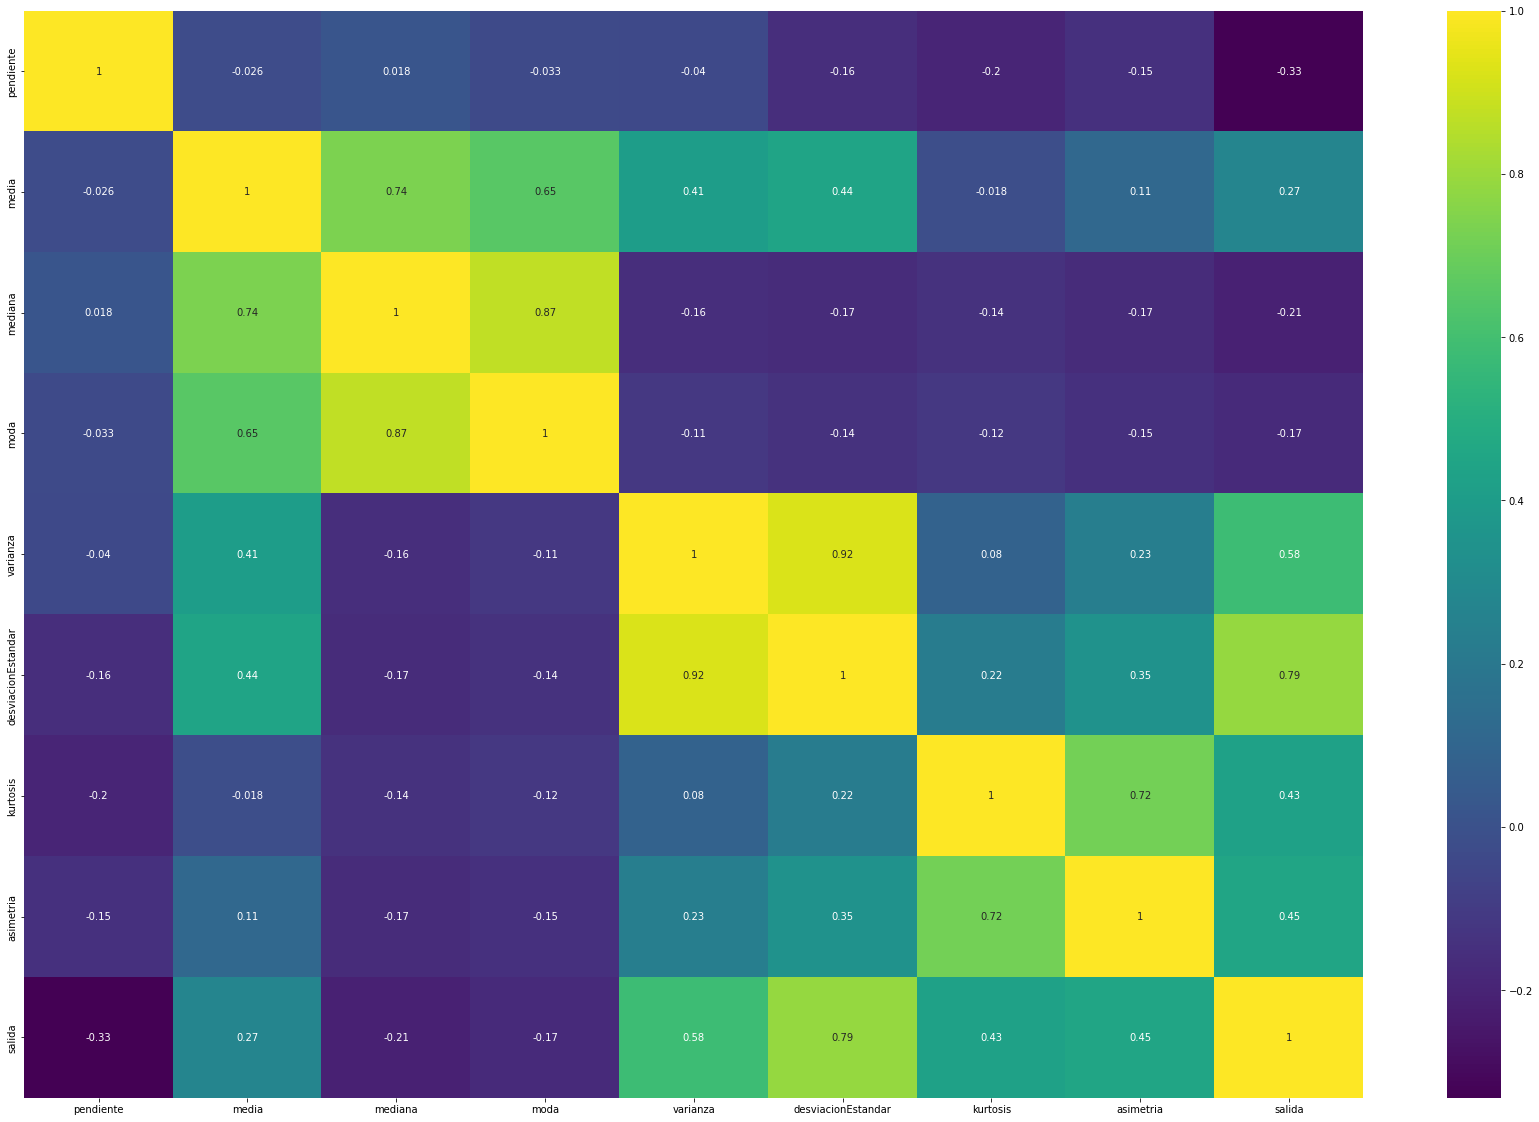

In [4]:
corrmat=df.corr()
top_corr_feature=corrmat.index
plt.figure(figsize=(30,20))
# Para graficar la matriz
g=sns.heatmap(df[top_corr_feature].corr(),annot=True,cmap='viridis')

Como podemos ver en la matriz de correlacion las mejores caracterisiticas para predecir el comportamiento del modelo son:   
1.  media   
2.  varianza  
3.  desviacionEstandar  
4.  kurtosis   
5.  asimetria

Tambien se recomienda que nuestro conjunto de datos sea mayor o igual de 400.000 para evitar demoras con la compilacion.

Entonces con el siguiente proceso ajustamos nuestra data para poder seguir con la preparacion de los datos.


In [7]:
data = df[['media','varianza','desviacionEstandar','kurtosis','asimetria','salida']]
data = data.head(400000)
data


,media,varianza,desviacionEstandar,kurtosis,asimetria,salida
0,0.2545,1.132965,1.064408,0.529401,1.436697,1
1,-0.1475,0.001529,0.039099,0.832477,-0.537550,0
2,0.2755,1.178025,1.085368,0.844009,1.516941,1
3,-0.1215,0.000813,0.028509,0.519649,-0.472923,0
4,0.3010,1.176754,1.084783,0.554570,1.437265,1
...,...,...,...,...,...,...
399995,-0.2160,0.000479,0.021886,3.694824,2.175028,0
399996,0.3120,1.190371,1.091041,1.468644,1.727748,1
399997,0.0210,0.054344,0.233118,3.878740,2.219468,0
399998,0.2560,1.165489,1.079578,1.801033,1.807126,1


### Exploracón de la información
---

En esta fase, exploramos nuestros registros en busca de factores que nos puedan generar un sesgo al momento de crear un modelo de clasificación.

Primero veamos la cantidad de datos que tenemos, y como se encuentran distribuidos en sus respectivas clase

1    200000
0    200000
Name: salida, dtype: int64



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


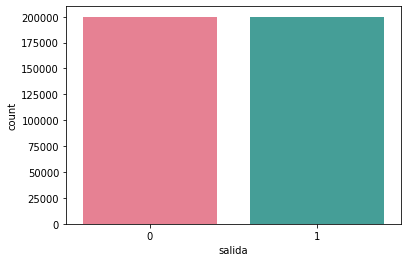

In [11]:
print(data['salida'].value_counts())
print("")
sns.countplot(data['salida'], palette='husl')

Ya viendo como se encuentran nuestros datos con respecto a su salida, vamos a verificar si tenemos valores nulos, los cuales eliminamos porque estos valores no aportan nada al momento de entrenar y probar un modelo.

In [12]:
data.isnull().sum()

media                   0
varianza                0
desviacionEstandar      0
kurtosis              529
asimetria             529
salida                  0
dtype: int64

Con la siguiente celda procedemos a eliminar los datos nulos

In [14]:
data = data[data['kurtosis'].notna()]
data = data[data['asimetria'].notna()]
data.isnull().sum()

media                 0
varianza              0
desviacionEstandar    0
kurtosis              0
asimetria             0
salida                0
dtype: int64

Una vez verificado que no tenemos datos nulos, se tiene que recorrer nuestra información en busca de datos atipicos en nuestros registro, ya que al momento de leer las señales algunos latidos no tenia el mismos espacio entre si, por lo que algunas ventanas no recogian el correcto espacio del comportamiento, por ende a estos datos serian atipicos porque no siguen el comportamiento de nuestra ventana

El algoritmo para hacer esto es el siguiente:

In [16]:
def IdentificarAtipicos(df, ft, valorAlfa):
    q1 = df[ft].quantile(0.25)
    q3 = df[ft].quantile(0.75)
    iqr = q3 - q1
    
    bigote_inferior = q1 - valorAlfa * iqr
    bigote_superior = q3 + valorAlfa * iqr
    
    ls = df.index[(df[ft]<bigote_inferior) | (df[ft] > bigote_superior)]
    return ls

def eliminar(df, index):
    index = sorted(set(index))
    df = df.drop(index)
    return df

aux = ['media','varianza','desviacionEstandar','kurtosis','asimetria']
valor_alpha = 1.5
index_list = []
for i in aux:
  index_list.extend(IdentificarAtipicos(data, i,valor_alpha))

columnsa = ["indicesss"]
df_index = pd.DataFrame(index_list,columns = columnsa)
df_index.duplicated().sum()
df_index = df_index.drop_duplicates()
final_index_list = df_index["indicesss"]
data = eliminar(data,final_index_list)
data

,media,varianza,desviacionEstandar,kurtosis,asimetria,salida
0,0.2545,1.132965,1.064408,0.529401,1.436697,1
2,0.2755,1.178025,1.085368,0.844009,1.516941,1
4,0.3010,1.176754,1.084783,0.554570,1.437265,1
6,0.2535,1.147553,1.071239,0.729990,1.484499,1
8,0.1895,1.050265,1.024824,0.594927,1.450194,1
...,...,...,...,...,...,...
399995,-0.2160,0.000479,0.021886,3.694824,2.175028,0
399996,0.3120,1.190371,1.091041,1.468644,1.727748,1
399997,0.0210,0.054344,0.233118,3.878740,2.219468,0
399998,0.2560,1.165489,1.079578,1.801033,1.807126,1


Ya que con el DataSet listo para entrenamiento, observamos nuevamente la distribucion de los datos para ver si hay cambios

1    191598
0    153759
Name: salida, dtype: int64



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


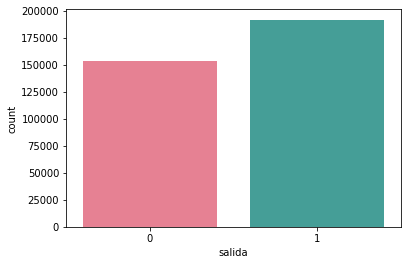

In [17]:
print(data['salida'].value_counts())
print("")
sns.countplot(data['salida'], palette='husl')

Al final del proceso de exploracion de información, podemos ver un desbalanceo de clases favorable a la clase 1, lo cual puede causar que nuestro modelo presente sesgos de información y por ende el desempeño del modelo se puede ver afectado. Por cuestiones de alcance del parcialy de la materia se decide pasar por alto este problema.

### Creacion Del Modelo
---

El modelo que se usa para clasificar nuestro comportamiento va ser el de **MLPClassifier** el cual se le optimizaron los hiperparametros mediante el de la libreria de **RandomizedSearchCV ** con una validacion cruzada de 5 ya que esta resulto ser la mas eficiente.

los parametros que se optimizaron son:
1.  hidden_layer_sizes
2.  activation
3.  learning_rate_init
4.  tol
5.  max_iter

El codigo del modelo es el siguiente: 

In [19]:
X = data[['media','varianza','desviacionEstandar','kurtosis','asimetria']]

y = data['salida']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    train_size=0.3,
                                                    )

In [22]:
mlp_gs = MLPClassifier()
parameters = {
    'hidden_layer_sizes':[(100,),(10,50,10),(20,),(100,100)],
    'activation':['logistic', 'tanh', 'relu'],
    'learning_rate_init':np.arange(0.001,0.005,0.001),
    'tol':np.arange(0.001,0.005,0.001),
    'max_iter':np.arange(200,1000,100)
}
RDSCV= RandomizedSearchCV(mlp_gs, 
                                       parameters,
                                       cv=5, 
                                       n_iter=3)

In [23]:
RDSCV.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_iter=3,
                   param_distributions={'activation': ['logistic', 'tanh',
                                                       'relu'],
                                        'hidden_layer_sizes': [(100,),
                                                               (10, 50, 10),
                                                               (20,),
                                                               (100, 100)],
                                        'learning_rate_init': array([0.001, 0.002, 0.003, 0.004]),
                                        'max_iter': array([200, 300, 400, 500, 600, 700, 800, 900]),
                                        'tol': array([0.001, 0.002, 0.003, 0.004])})

Ahora vamos ver el desempeño del modelo en nuestra fase de entrenamiento y tambien cuales fueron los mejores paramentros del modelos para alcnzar el mejor desempeño.

In [24]:
print(RDSCV.best_score_)
print(RDSCV.best_params_)

0.9925777338751539
{'tol': 0.003, 'max_iter': 400, 'learning_rate_init': 0.004, 'hidden_layer_sizes': (100, 100), 'activation': 'tanh'}


Y por ultimo vemos el resultado cuando se prueba el modelo con el conjunto de datos de prueba.

In [25]:
pred_y = RDSCV.predict(X_test)
f1_score(y_test, pred_y)

0.9937131366290152

Para observar mejor el desempeño de neustros modelo usamos una matriz de confusion y el reporte de clasificacion.

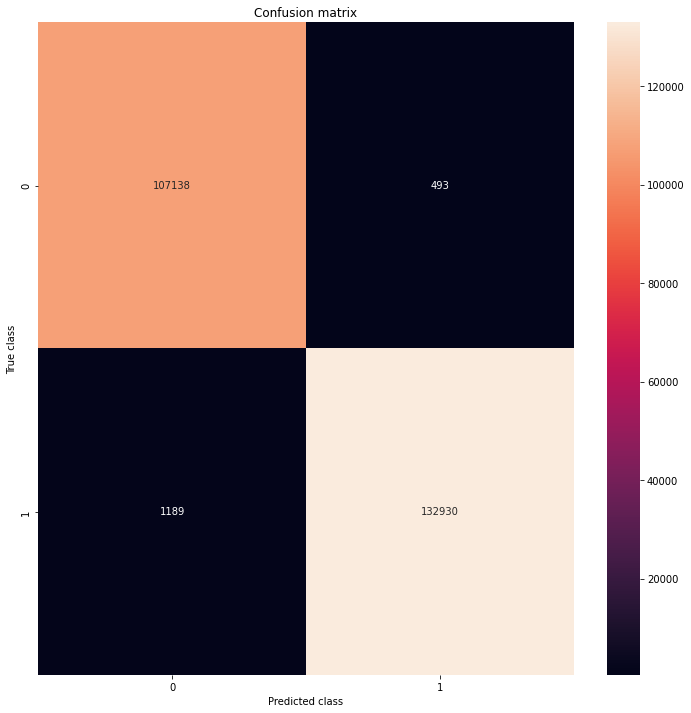

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    107631
           1       1.00      0.99      0.99    134119

    accuracy                           0.99    241750
   macro avg       0.99      0.99      0.99    241750
weighted avg       0.99      0.99      0.99    241750



In [26]:
conf_matrix = confusion_matrix(y_test, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print (classification_report(y_test, pred_y))

Como podemos ver en la matrix el modelo clasifico de manera incorrecta 493 registros de la clase 0 como clase 1, esto debido a el sesgo que se genera con el desbalanceo de clases que se tiene presente.

### Prueba del Modelo con la Señal

---

Para la demostracion del modelos, usamos una señal del conjunto de datos para realizar la prueba, la señal escogida fue la del paciente **16420**.  
Con la siguiente celda podemos cargar la informacion:

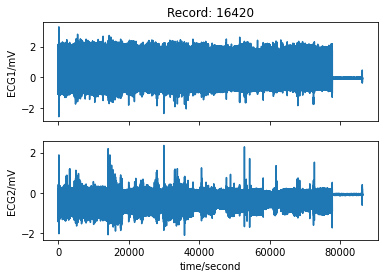

In [70]:
registro=wfdb.rdrecord("db/16420")
signal = registro.p_signal
signal1 = signal[:,0] 
wfdb.plot_wfdb(registro)


Se decide probar el modelo con la siguiente fraccion de la señal **signal1[:900]** y una ventana con un rango total de **25**, por lo que en consecuencia vamos a tener un total de 36 ventanas totales para pasarle a nuestro modelo y haga la prediccion del comportamiento.

In [64]:
rango_ventana = 25   #total de la ventana de observacion
aux = rango_ventana
datos = []
inicio = 0
     
for x in range(0,36):
  ventana = signal1[inicio:rango_ventana] #['media','varianza','desviacionEstandar','kurtosis','asimetria']
  media = stats.mean(ventana)
  varianza = stats.pvariance(ventana)
  desviacionEstandar = stats.pstdev(ventana)
  kurt = kurtosis(ventana)
  asime = skew(ventana)
  caracteristicas = [media,varianza,desviacionEstandar,kurt,asime]
  datos.append(caracteristicas)
  inicio = rango_ventana
  rango_ventana = rango_ventana + aux


colums = ['media','varianza','desviacionEstandar','kurtosis','asimetria']
lst = datos
df_señal = pd.DataFrame(lst, columns = colums)
df_señal





,media,varianza,desviacionEstandar,kurtosis,asimetria
0,-0.0454,0.001252,0.035381,-1.085516,-0.053683
1,-0.0062,0.000171,0.013060,-0.318462,0.438046
2,0.0446,0.239044,0.488921,5.288146,1.772471
3,-0.0802,0.001513,0.038897,-1.332627,0.162156
4,-0.0486,0.000815,0.028549,3.688440,-1.924959
5,-0.0298,0.017057,0.130602,4.377333,1.825888
6,-0.0374,0.286106,0.534889,5.796980,2.317281
7,-0.0934,0.000709,0.026635,-0.237960,-0.756207
8,-0.0734,0.005373,0.073304,-0.764921,0.355943
9,-0.0438,0.288043,0.536696,5.704063,2.227232


Le pasamos la informacion del modelo para que nos haga la respectiva clasificación a el modelo y nos muestre los resultados de forma grafica para comparlos con la grafica de la fraccion de señal.

In [72]:
X_test_señal = df_señal[['media','varianza','desviacionEstandar','kurtosis','asimetria']]
predict = RDSCV.predict(X_test_señal)
df_señal['prediccion'] = predict

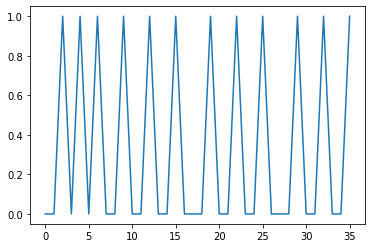

In [73]:
plt.plot(predict)

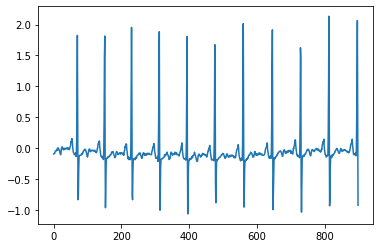

In [71]:
plt.plot(signal1[:900])

0    24
1    12
Name: prediccion, dtype: int64



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


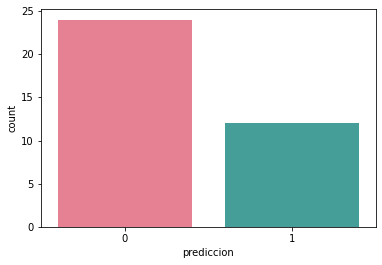

In [76]:
print(df_señal['prediccion'].value_counts())
print("")
sns.countplot(df_señal['prediccion'], palette='husl')

# Conclusiones
---
Como se pueden ver en los resultados de la prediccion se tienen que tenemos 12 latidos y 24 no latidos de nuestras ventanas de observación, por lo que si comparamos visualmente nuestro modelo vemos que ha tenido un error calificando los latidos, ya que en ese fragmento de señal solo podemos tener 12 latidos posibles. Esto se puede deber a que como anteriormente se ha mencionado el modelo puede estar sesgado para la clase que representa el comportamiento del los latidos, una dificultad es que solo con la grafica de las predicciones no se podria evaluar el comportamiento, porque no se puede ver bien a lo largo toda la señal, pero los comportamientos se asimilan a los de una señal.

Las cosas que podrian mejorar el desempeño del modelo seguramente sea solucionar el problema de desbalance de clases que se presenta en el conjunto de datos.